### Business Scenario

RestoreMasters is a car restoration company based in New York, USA. Within short span of time, this company has become renowned for restoring vintage cars. Their team takes great pride in each of their projects, no matter how big or small. They offer paint jobs, frame build-ups, engine restoration, body work etc. They restore cars of various origins including USA, Europe and Asia. 

The management wants to expand their business by increasing the capacity of the number of cars that can be restored. They want to generate greater revenue for the company through cost cutting and providing a data driven approach to their current process. They feel that the insights from existing data will help them in making data-driven decisions and also automate some of the key tasks in the process. We will be building two models - 1) to automate the classification of incoming cars 2) predict the mileage of the cars. 

<hr style="border:2px solid gray">

#**STEP: 0/4** - Run the following lines of code and move to Step 1. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error,accuracy_score
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imblearn_pipeline
from sklearn.pipeline import make_pipeline as sklearn_pipeline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
%%capture

!pip install category_encoders==2.*
from category_encoders import OrdinalEncoder

In [ ]:
#Update the DATA_PATH variable

import sys

if 'google.colab' in sys.modules:
  # If you're on Colab:
  DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/ds_code_along_unit_2/main/data/restoremasters/'
else:
  # If you're working locally:
  DATA_PATH = '..../data/'

In [ ]:
# importing the dataset to Pandas DataFrame: cars_df
cars_df=pd.read_csv(DATA_PATH +'auto_mpg.csv')

In [ ]:
# display the data in DataFrame: cars_df
cars_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [ ]:
# Get the concise summary of DataFrame: cars_df
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [ ]:
# Replacing missing values with mean horsepower of cars with similar cylinders and model_year
cars_df['horsepower'] = cars_df.groupby(['cylinders', 'model_year'])['horsepower'].apply(lambda x: x.fillna(x.mean()))

In [ ]:
# checking for missing values in columns of the DataFrame: cars_df
cars_df.isna().any()

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model_year      False
origin          False
name            False
dtype: bool

In [ ]:
# get the duplicate records in the DataFrame: cars_df
cars_df[cars_df.duplicated()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name


In [ ]:
# dropping the duplicate records in the DataFrame: cars_df
cars_df.drop_duplicates(inplace=True)
cars_df.duplicated().sum()

0

In [ ]:
# finding the upper and lower limit of horespower and acceleration columns

def find_outlier_limits(col_name):
    Q1,Q3=cars_df[col_name].quantile([.25,.75])
    IQR=Q3-Q1
    low=Q1-(1.5* IQR)
    high=Q3+(1.5* IQR)
    return (high,low)

high_hp,low_hp=find_outlier_limits('horsepower')
print('Horsepower: ','upper limit: ',high_hp,' lower limit: ',low_hp)
high_acc,low_acc=find_outlier_limits('acceleration')
print('Acceleration: ','upper limit: ',high_acc,' lower limit:',low_acc)

# Replacing outlier values in horespower and acceleration columns with respective 
# upper and lower limits

cars_df.loc[cars_df['horsepower']>high_hp,'horsepower']=high_hp
cars_df.loc[cars_df['acceleration']>high_acc,'acceleration']=high_acc
cars_df.loc[cars_df['acceleration']<low_acc,'acceleration']=low_acc

Horsepower:  upper limit:  200.0  lower limit:  0.0
Acceleration:  upper limit:  22.2  lower limit: 8.8


<hr style="border:2px solid gray">

---



#**STEP: 1/4** - Create new features

In [ ]:
# Extracting the company name from the name column
cars_df['company']=cars_df['name'].apply(lambda x:x.split()[0])
cars_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,company
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu,chevrolet
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320,buick
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite,plymouth
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst,amc
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino,ford


In [ ]:
# based on mpg and cylinders, creating a new column - car_type (hatchback, sedan, SUV, sports)

cars_df.loc[(cars_df['cylinders']==3),'car_type']='Hatchback'
cars_df.loc[(cars_df['cylinders']==4) & (cars_df['mpg']>=30),'car_type']='Hatchback'
cars_df.loc[(cars_df['cylinders']==5),'car_type']='Sedan'
cars_df.loc[(cars_df['cylinders']==4) & (cars_df['mpg']<30),'car_type']='Sedan'
cars_df.loc[(cars_df['cylinders']==6),'car_type']='SUV'
cars_df.loc[(cars_df['cylinders']==8),'car_type']='Sports'

In [ ]:
# drop the ```cylinders``` and ```name``` columns

cars_df.drop(columns=['cylinders','name'],inplace=True)

<hr style="border:2px solid gray">

#**STEP: 2/4** - Check target distribution

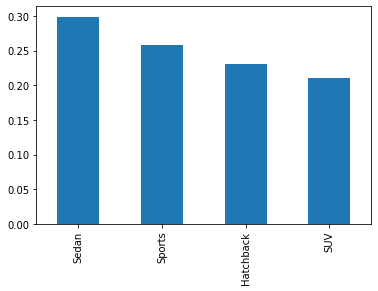

In [ ]:
# discrete target = classification
cars_df['car_type'].value_counts(normalize=True).plot(kind='bar');

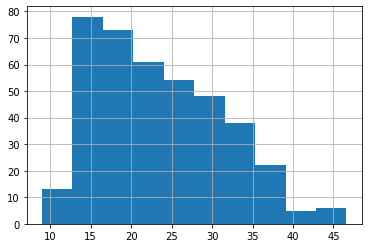

In [ ]:
# continuous target = regression
cars_df['mpg'].hist();

In [ ]:
# determine the amount of skewness

cars_df['mpg'].skew(axis=0, skipna=True) 

0.45706634399491913

<hr style="border:2px solid gray">

#**STEP: 3/4** - Balancing an imbalanced target (for classification)

In [ ]:
# Split the data into Feature Matrix and Target Vector
target_clf = 'car_type'
y_clf = cars_df[target_clf]
X_clf = cars_df.drop(columns=[target_clf])

# Split data into Train and Test Sets
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size = 0.2, random_state = 42)

In [ ]:
# Build a Random Forest Classifier Model

model_rf_clf = imblearn_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    SMOTE(random_state=42,n_jobs=-1),
    RandomForestClassifier(random_state=42,n_jobs=-1)
);

model_rf_clf.fit(X_train_clf, y_train_clf);

In [ ]:
# Dictionary containing the information to sample the dataset.

model_rf_clf.named_steps['smote'].sampling_strategy_

OrderedDict([('Hatchback', 13), ('SUV', 21), ('Sports', 12)])

In [ ]:
# check your metrics (If you do not delete cylinders, your test accuracy will be 100%)
print('Test Accuracy:', accuracy_score(y_test_clf, model_rf_clf.predict(X_test_clf)) )

Test Accuracy: 0.9625


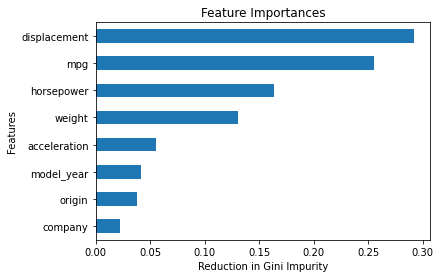

In [ ]:
# Plot the top ten feature importances

importances = model_rf_clf.named_steps['randomforestclassifier'].feature_importances_
features = model_rf_clf.named_steps['ordinalencoder'].get_feature_names()
feat_imp = pd.Series(importances, index=features).sort_values(key=abs)
feat_imp.tail(20).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity')
plt.ylabel('Features')
plt.title('Feature Importances');

<hr style="border:2px solid gray">

#**STEP: 4/4** - Log transformation of skewed target (for regression)

In [ ]:
# Split the data into Feature Matrix and Target Vector
target_reg = 'mpg'
y_reg = cars_df[target_reg]
X_reg= cars_df.drop(columns=[target_reg])

# Split data into Train and Test Sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size = 0.2, random_state = 42)

In [ ]:
# Random Forest Regressor

model_rf_reg = sklearn_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=42,n_jobs=-1)
);


In [ ]:
# log transform your target (training set)
y_train_reg_log = np.log1p(y_train_reg)

In [ ]:
# fit your chosen model to this log tranformed target
model_rf_reg.fit(X_train_reg, y_train_reg_log);

In [ ]:
# get your predictions for this log tranformed target
y_pred_reg_log = model_rf_reg.predict(X_test_reg)

In [ ]:
# reverse log tranform your predictions
y_pred_reg = np.expm1(y_pred_reg_log)

In [ ]:
# check your metrics
print('Test MAE:', mean_absolute_error(y_test_reg, y_pred_reg))

Test MAE: 1.5973599890619254


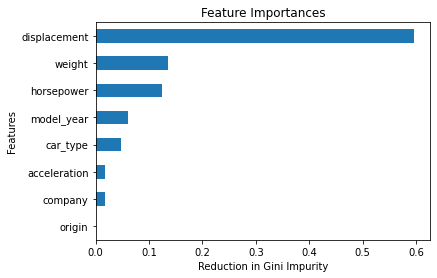

In [ ]:
# Plot the top ten feature importances

coefficients = model_rf_reg.named_steps['randomforestregressor'].feature_importances_
features = model_rf_reg.named_steps['ordinalencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(20).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity')
plt.ylabel('Features')
plt.title('Feature Importances');